# Modeling Agricultural Variables
## Python modules

In [1]:
import warnings
import time
import os

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas as gpd

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Mild Preprocessing
### 1. Load in the data

First, we load in the feature data. This data was aggregated in the ___ notebook

In [2]:
# Let's read in the new concatenated features:
features = pd.read_feather("/capstone/mosaiks/repos/modeling/data/sentinel_rgb_features_sea_save_2023_04_24.feather")


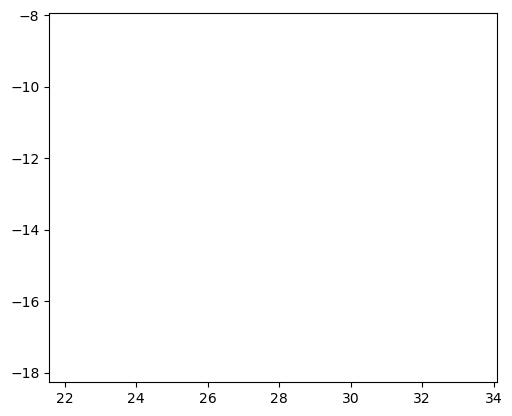

In [3]:
# Replace 'longitude' and 'latitude' with the appropriate column names in your DataFrame
geometry = gpd.points_from_xy(features.lon, features.lat)
gdf = gpd.GeoDataFrame(features, geometry=geometry)

# Step 4: Plot the data
gdf.plot(markersize=0.000001)
plt.show()

### Ground-Truth Data
Next, we read in our ground truth data, which was processed in the preprocessing notebook

In [5]:
# Name list because gpd doesn't read in column names correctly
names = ["sea_unq", "year", "total_area_planted_ha", "total_area_harv_ha", "total_area_lost_ha", "total_harv_kg", "yield_kgha", "frac_area_harv", "frac_area_loss", "area_lost_fire", "maize", "groundnuts", "mixed_beans",  "popcorn", "sorghum", "soybeans", "sweet_potatoes", "bunding", "monocrop", "mixture", "frac_loss_drought",  "frac_loss_flood", "frac_loss_animal", "frac_loss_pests", "frac_loss_soil", "frac_loss_fert", "prop_till_plough",  "prop_till_ridge", "prop_notill", "prop_hand", "prop_mono", "prop_mix", "log_maize",  "log_sweetpotatoes", "log_groundnuts", "log_soybeans", "loss_ind", "drought_loss_ind", "flood_loss_ind", "animal_loss_ind", "pest_loss_ind", "geometry"]



# Read in the survey data
country_sea = gpd.read_file('/capstone/mosaiks/repos/preprocessing/data/ground_data_spatial/updated_data.shp')
country_sea.columns = names

We're going to make another object `sea_unq_join` which contains the spatial information and a unique key for each SEA. This will be handy later, when we need to join the features to the ground-truth data.

In [6]:
# Filter country_sea for unique values of 'seq_unq' and 'geometry'
sea_unq_join = country_sea[['sea_unq', 'geometry']].drop_duplicates()

# Display the filtered DataFrame
print(sea_unq_join)


      sea_unq                                           geometry
0           1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...
10          2  POLYGON ((27.99349 -13.46497, 27.99352 -13.464...
20          3  POLYGON ((28.09909 -13.51864, 28.09867 -13.516...
29          4  POLYGON ((28.31924 -13.42915, 28.31911 -13.426...
38          5  POLYGON ((28.39982 -13.51544, 28.40012 -13.514...
...       ...                                                ...
3571      388  POLYGON ((25.07771 -14.63920, 25.07732 -14.638...
3578      389  POLYGON ((22.74142 -14.00343, 22.73856 -14.002...
3585      390  POLYGON ((23.08604 -14.20026, 23.08957 -14.202...
3592      391  POLYGON ((24.36764 -16.62208, 24.36564 -16.621...
3599      392  POLYGON ((23.23962 -16.31204, 23.23876 -16.312...

[392 rows x 2 columns]


### 2. Organize the features by growing season



In [ ]:
# Organize the features by growing season
# Carry months October, November, and December over to the following year's data
# These months represent the start of the growing season for the following year's maize yield
year_end = 2022

features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features_gs = features[features['year'] <= year_end]

features_gs.sort_values(['year', 'month'], inplace=True)

### 3. Convert the features into a geo dataframe

In [ ]:
# Create a geodataframe of the new features
features_new_gdf = gpd.GeoDataFrame(
    features_gs, 
    geometry = gpd.points_from_xy(x = features_gs.lon, y = features_gs.lat), 
    crs='EPSG:4326'
)

In [ ]:
features_new_gdf

## Pivot Wider by months

Since we want each row to represent one location per year, we can use the .unstack() function to pivot wider all rows with the same lat/lon and year. This results in a dataframe with 12,000 columns (1,000 columns for each month). 

In [ ]:
# Store the 'geometry' column separately before unstacking
geometry_col = features_new_gdf[['lon', 'lat', 'geometry']].drop_duplicates(subset=['lon', 'lat'])

# Perform the unstacking operation without the 'geometry' column
features_gs_no_geometry = features_gs.drop(columns=['geometry'])
features = features_gs_no_geometry.set_index(['lon', 'lat', 'year', 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

# Merge the 'geometry' column back into the features DataFrame
features = features.reset_index().merge(geometry_col, on=['lon', 'lat'])


In [ ]:
features

In [ ]:
# Drop the unwanted 'index' and 'geometry' columns
features = features.filter(regex='^(?!index_)')


# Convert the 'features' DataFrame to a GeoDataFrame
features_gdf = gpd.GeoDataFrame(features, geometry=features['geometry'], crs='EPSG:4326')

In [ ]:
features.iloc[:, 12000:]

## Join features to ground data

In [ ]:
# Now lets combine the sea data 
spatial_join = gpd.sjoin(features_gdf, sea_unq_join, how='right', predicate = 'within')

In [ ]:
spatial_join

In [ ]:
features_join = spatial_join.merge(country_sea, on=['year', 'sea_unq'], how='inner')

In [ ]:
# Drop the redundant independent lon and lat columns because now that they are in a separate geometry column
features_join = features_join.drop(['geometry_x'], axis = 1)

In [ ]:
features_join.iloc[:, 12000:]

In [ ]:
features_join.iloc[:, 12003:]

In [ ]:
# Set some parameters 
# Number of features:
num_features = 1000

# Imputing
impute_manual = False

### Impute missing values

Imputing "manually" by descending group levels imputes NA values in multiple "cascading" steps, decreasing the proportion of inputed values with each step. First, the NA values are imputed at by both `year` and `geometry`, which should yield imputed values that most closely match the feature values that would be present in the data if there was no clouds obscuring the satellite images. Next, the remaining NA values that could not be imputed by both `year` and `district` are imputed by only `district`. Lastly, the remaining NA vlaues that could not be imputed by both `year` and `district` or by just `district` are imputed by `year` only. This option gives the user more control and transparency over how the imputation is executed.

Imputing using `scikit learn`'s simple imputer executes standard imputation, the details of which can be found in the `scikitlearn` documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

The imputation approach depends on the selection made at the top of this notebook for `impute_manual`.

In [ ]:
# Extract the size of the features dataframe
rows, cols = features_join.shape

# compute the number of feature cells in the features dataframe
num_cells = rows * cols
num_cells

In [ ]:
features_join

In [ ]:
class bcolors:
    BL = '\x1b[1;34m' #GREEN
    GR = '\x1b[1;36m' #GREEN
    YL = '\x1b[1;33m' #YELLOW
    RD = '\x1b[1;31m' #RED
    RESET = '\033[0m' #RESET COLOR

In [ ]:
# Replace all infinity values with NaN
features_join = features_join.replace([np.inf, -np.inf], np.nan)
features_join = (
    features_join
    .fillna(features_join
            .groupby(['lat', 'lon'], as_index=False)
            .transform('median')
            )
)
features_join = (
    features_join
    .fillna(features_join
            .groupby(['sea_unq'], as_index=False)
            .transform('median')
            )
)

In [ ]:
# Notes: Have to change the year, get an error rn. Also, check to make sure the number of cells is correct
features_join = features_join.replace([np.inf, -np.inf], np.nan)

if impute_manual:
    ln_ft = len(features_join)
    ln_na = len(features_join.dropna())
    print(f'Starting total row count: {bcolors.BL}{ln_ft}{bcolors.RESET}',
          f'\nPre-Impute NaN row count: {bcolors.RD}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPre-Impute NaN row %: {bcolors.RD}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPre-Impute NaN cell %: {bcolors.RD}{(features_join.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 1: Filling NaN values by month, year, and district group average')
    features_join = (
        features_join
        .fillna(features_join
                .groupby(['year', 'sea_unq'], as_index=False) 
                .transform('mean')
               )
    )
    ln_ft = len(features_join)
    ln_na = len(features_join.dropna())
    print(f'Post step 1 NaN row count: {bcolors.YL}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 1 NaN row %: {bcolors.YL}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 1 NaN cell %: {bcolors.YL}{(features_join.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 2: Filling NaN values by month and district across group average')
    features_join = (
        features_join
        .fillna(features_join
                .groupby(['sea_unq'], as_index=False)
                .transform('mean')
               )
    )
    ln_ft = len(features_join)
    ln_na = len(features_join.dropna())
    print(f'Post step 2 NaN row count: {bcolors.GR}{ln_ft - ln_na}{bcolors.RESET}',
          f'\nPost step 2 NaN row %: {bcolors.GR}{((ln_ft - ln_na) / ln_ft)*100:.02f}{bcolors.RESET}',
          f'\nPost step 2 NaN cell %: {bcolors.GR}{(features_join.isna().sum().sum() / num_cells)*100:.02f}{bcolors.RESET}',
          f'\n\nStep 3: Drop remaining NaN values\n')
    features_join = features_join.dropna(axis=0)
    print(f'Ending total row count: {bcolors.BL}{len(features_join)}{bcolors.RESET}')
    
else:
    # Store the geometry column separately
    geometry_col = features_join['geometry_y']
    # Remove the geometry column from the DataFrame
    features_join = features_join.drop(columns=['geometry_y'])
    features_join = features_join.set_index(['year', 'sea_unq'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features_join)
    features_join[:] = imputer.transform(features_join)
    features_join = features_join.reset_index()
    # Add the geometry column back to the DataFrame
    features_join['geometry'] = geometry_col

In [ ]:
features_join = features_join[features_join['year'] != 2019]

In [ ]:
#remove years 2019 and 2020 from features join data 
print(features_join['year'].unique())


features_join = features_join.drop(['lat', 'lon'], axis = 1)

### Save copy of processed features before sumarizing training features to district level

Duplicate the features dataframe at this stage so we can retain a copy of features at point resolution for all years available, which is `2013/2014/2016-2021`.

    - The start year is `2016` if the satellite selected is Sentinel 2 (due to the fact that Sentinel 2 launched in June of `2015`)
    - The start year is `2013` if the satellite selected is Landsat 8 and the month range selected was anything besides all months (due to the fact that Landsat 8 launched in February of `2013`)
    - The start year is `2014` if the satellite selected is Landsat 8 and the month range selected was all months
    
This duplicated dataframe we create in the following code is called `features_all_years`. The purpose for this dataframe comes into play after the model is trained; we will be able to plug in point-resolution features from _any and all_ years from this dataframe into the trained model and observe how the model predicts crop years across space and time. It would be interesting to plot these features for each year sequentially to show how the crop prediction landscape changes by year. These point-resolution features increase the spatial resolution of the ground-truth crop data we have for the years through 2018, because our ground-truth crop data is at a the coarser  district-resolution. Furthermore, these point-resolution features are the _only_ crop data we have for the years 2020-2021. The reason we lack data from 2019 is because the Zanbia Sattistics Agency has not yet released their Crop Forecast Survey data for that year. The reason we do not have data for 2020-2021 is because Covid-19 prevented any Crop Forecast Surveys from being conducted. 


After we create the dataframe `features_all_years`, we are free to further process the original features dataframe, `features_join`, in order to train the model with these features and their paired ground-truth crop yields. Processing this dataframe further requires us to subset the years to the start year through the years for which we have crop data: `2013/2014/2016-2019`. This dataframe is called `features_through_2019`. The reason we subset this dataframe is because we are training the model using _supervised_ machine learning, which means we are feeding it only features that have ground-truth crop data accosicated with them.

In [ ]:
features_all_years = features_join.copy()

# assign the geometry column to features_2014_2021 so it can serve 2 purposes:
# 1. plotting features sequentially by year
# 2. the entire dataframe can be fed into the model after the model is trained on only the summarized features for 2014-2018 and the associated crop data
# moving forward in the immediate sections, summarize the `features` dataframe to district level

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean, depending on the selection at the top of this notebook for `weighted_avg`. 

In [ ]:
# check the order of the columns in the dataframe that will be summarized and then fed into the ridge regression in order to train the model
# we care about the order of columns specifically because in the following steps we assign only the feature columns to an object, so we need to know which 3 columns to omit by indexing
features_join.columns

The output above show that the 3 columns that are _not_ features are the first 2 columns `year` and `district`, and the last column, `crop_perc`.

In [ ]:
# check the shape to the dataframe as a sanity check
features_join.shape

In [ ]:
features_join.iloc[:, 12002]

The output above shows the number of rows and columns in the dataframe, respectively. Recall that the number of rows represents the number of points for which we have features, and the number of columns is all features for all months selected plus the columns `year`, `district`, and `crop_perc`. There are 13866 rows, meaning that is the amount of training points we have to feed into the model _before they are summarized to district level_, so this number will shrink after we summarize to district level. There are 12003 columns, which will not change after we summarize the features to district level. The number of columns that we include in the features object in the next chunk will be this number minus the 3 non-feature columns.

In [ ]:
# create object that contains only feature columns, rather than all columns that would include `district`, `year`, and `crop_perc`
# python index starts at 0, so here we specify to retain columns starting at 3 through every column besides the last column
# the columns we omit stay in the dataframe, because we assign the selected columns to an object, but the omitted columns are not included in the calculation in the next chunk
var_cols = features_join.columns[3:12003].values.tolist()

# call the object `var_cols` to check that it only includes feature columns, but do not view it in list format because it is more readable not as a list 
features_join.columns[3:12003]
# these are all the feature columns that will be fed into the `weighted_avg` calculation in the next chunk

In [ ]:
%%time
# Group by 'year' and 'sea_unq' and calculate the mean for the specified columns
grouped_features = features_join.groupby(['year', 'sea_unq']).mean()


Now that the features have been summarized to district and year, there are fewer rows. The dataframe we were working with before this step,  `features_through_2018`, had 13866 rows that represented points. Now we have 216 rows, as shown by the following output. Notice we still have all 12003 columns. 

In [ ]:
grouped_features.iloc[:, 1:]

## Model

### Define `x`'s and `y`'s that will be a part of training the model

Since our independent variable is the features, these are the `x`'s. Our dependent variable is the crop yield in metric tonnes per hectare planted, so that will be the `y`'s.

In [ ]:
# Separate features (X) and target variables (y)
X = grouped_features.iloc[:, 1:12000]
y = grouped_features['ar_____']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Split into train and test sets

This step is executed right before training the model so we can train on 80% of the data and preserve 20% for testing.

In [ ]:
print("Number of total points: ", len(X), "\n", 
      "Number of training points: ", len(X_train), "\n",
      "Number of testing points: ", len(X_test), sep = "")

### Train model using cross-validated ridge regression

Please see the documentation for the function that executes this regression [here.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

In [ ]:
# ridge_cv_random = RidgeCV(cv = 5, alphas = np.linspace(2, 10, num = 20))
# ridge_cv_random.fit(X_train, y_train)

In [ ]:
ridge_cv_random = RidgeCV(cv = 5, alphas = np.logspace(-8, 8, base = 10, num = 17))
ridge_cv_random.fit(X_train, y_train)

In [ ]:
print(f"Estimated regularization parameter: {ridge_cv_random.alpha_}")

In [ ]:
print(f"Validation R2 performance: {ridge_cv_random.best_score_:0.2f}")

In [ ]:
y_pred = ridge_cv_random.predict(X_test)
y_pred

r=r2_score(y_test, y_pred)
print(r)

In [ ]:
# Initialize lists to store the predictions, RMSEs, and R-squared values
predictions = []
rmse_list = []
r2_list = []

# Loop through the target variables (columns)
for i in range(y_test.shape[1]):
    # Extract the true values and predictions for the current target variable
    y_test_i = y_test.iloc[:, i]
    y_pred_i = y_pred[:, i]
    
    # Compute the RMSE and R-squared
    rmse_i = np.sqrt(mean_squared_error(y_test_i, y_pred_i))
    r2_i = r2_score(y_test_i, y_pred_i)
    
    # Append the results to the corresponding lists
    predictions.append(y_pred_i)
    rmse_list.append(rmse_i)
    r2_list.append(r2_i)

# Print the RMSE and R-squared values for each target variable

for i, (column_name, rmse_i, r2_i) in enumerate(zip(y_test.columns, rmse_list, r2_list), start=1):
    print(f"{column_name}: R-squared = {r2_i:.4f}")

### Validation set $R^2$ performance

In [ ]:
print(f"Validation R2 performance: {ridge_cv_random.best_score_:0.2f}")

### Train set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(X_train), 0)
print(y_pred)
r2_train = r2_score(y_train, y_pred)

In [ ]:
print(f"Training R^2 = {r2_train:0.2f}\nPearsons r = {pearsonr(y_pred, y_train)[0]:0.2f}") 

In [ ]:
# Pearson r^2
pearsonr(y_pred, y_train)[0] ** 2

In [ ]:
# alternative way to calculate Training R^2
ridge_cv_random.score(x_train, y_train)

### Test set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)
r2_test = r2_score(y_test, y_pred)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {r2_test:0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [.75, .75], c = "k")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [ ]:
print(f"Testing set R^2 = {r2_test:0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Summary of both train and test data sets

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.axline([0, 0], [.75, .75], c = "k")
plt.scatter(y_pred, y_all, alpha=.9, s=15)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Observed", fontsize=15)
plt.text(
    0, .8, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_train:0.2f} - Train set",
)
plt.text(
    0, .75, fontsize=15, fontweight="bold",
    s=f"R$^2$={ridge_cv_random.best_score_:0.2f} - Validation set",
)
plt.text(
    0, .7, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_test:0.2f} - Test set",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_all_data.jpg', dpi=300)
plt.show()
plt.close()

### Use the trained model to predict crop yields over all years from 1km grid-cell resolution features 

Recall that after we executed imputation on all feature years in the dataframe `features`, we copied the dataframe and named it `features_all_years`. Now we can plug that into the model to visualize how our model performs over time.

In [ ]:
# recall the object we created earlier, before we split the features by year into those that would train the model 
# and those that would be fed into the trained model to predict crop yields
# in years for which we do not have crop data
features_all_years.head(3)

In the following chunk, we drop certain columns from `features_all_years` because we only need to feed the feature data into the model to generate predictions. Using the argument `axis = 1`, we specify that we are dropping columns rather than rows. 

In [ ]:
x_all = features_all_years.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)

In the following chunk, we execute the model on the features from the dataframe `features_all_years`. The crop yield predictions for each row populate a new column in the dataframe.

The model is run inside the `np.maximum()` function because if we run it without being wrapped inside function, some crop predictions are negative values, but we need them all to be positive because conceptually crop yields cannot be negative.

In [ ]:
features_all_years['yield_prediction'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [ ]:
# check out the dataframe with the new column of predictions
features_all_years.head(3)

The dataframe is already a geodataframe, so we do not have to convert it to one before mapping predictions. However, we do need to replace all the zero value crop percentage areas with `NA`. We do this by applying the `mask()` function. This function is similar to an if-else statement. If the value of the `crop_perc` is equal to 0, that value is replaced by the value of the second argument, which is `NA`. If the value of `crop_prec` is _not_ equal to zero, we retain the current value. The argument `inplace = True` executes this replacement in the same cell. 

In [ ]:
features_all_years['yield_prediction'].mask(features_all_years['crop_perc']==0, np.nan, inplace=True)

Recall that this dataframe has a geometry column, with latitude and longitude together. In order to map the predicted features, we separate this geometry column into separate `lon` and `lat` columns. 

In [ ]:
# extract the longitude and latitude from the geometry column, and make then into independent columns
features_all_years['lon'], features_all_years['lat'] = features_all_years.geometry.x, features_all_years.geometry.y

Plot the predicted features for each year:

In [ ]:
def scatter(x, y, c, **kwargs):
    plt.scatter(x, y, c=c, s = 1.25)
sns.color_palette("viridis", as_cmap=True)
g = sns.FacetGrid(
    features_all_years, 
    col="year", 
    col_wrap = 4, 
    height=5, 
    aspect=1
)
g.map(scatter, "lon", "lat", "yield_prediction")
g.set_axis_labels(r"Yield Prediction")
# save the figure and name the file so that it represents the model parameters that created the predictions
# plt.savefig(f'images/{feature_file_name}_all_predictions.jpg', dpi=300)

Plot the model's predicted features summarized to district level. In this visualization, we choose a specific year to examine rather than visualizing all years in one figure. Visualizing the the features summarized to district level is interesting because the crop data resolution provided by Zambia Statistics Agency is at the district level, and therefore it is easier to compare our model results to those ground-truth values when they are summarized to district level as well. Furthermore, our model's crop predictions for the years 2020 and 2021 might be more valuable when summarized to district level if Zambian governments, policy-makers, farmers, and researchers wish to use this data to determine crop imports, exports, and storage according to district summaries. 

In [ ]:
features_all_years_summary = (
    features_all_years
    .groupby(['district',"year"], as_index = False)['yield_prediction']
    .mean()
    .set_index('district')
)

In [ ]:
# join Zambia's shapefile to the summarized features to map the districts
# reset the index so it is a properly formatted dataframe
features_all_years_summary = features_all_years_summary.join(country_shp).reset_index()

Now that the geometries have been converted to districts from points, the geomatries are now polygons. There is still a row for each district for each year.

In order to change the year visualized, simply change the year in the following code and re-run the chunk.

In [ ]:
features_all_years_summary[features_all_years_summary.year == 2020].plot(column = "yield_prediction")

Plot a boxplot for each year to visualize the range and quantile distribution of each year's crop predictions, summarized to district level. This enables us to identify years with exceptional disparities between the predicted yields by district. It also allows us to identify years that have many outliers.

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="year", y="yield_prediction", data = features_all_years_summary)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Predicted Yield", fontsize=15)

Visualize the total crop yield predictions by year. This bar chart shows the sum of all the district crop yields.

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data = features_all_years_summary, estimator = sum)

## Yield and Residual Plots

Create a dataframe of residuals called `residuals_df` from the `features_summary` dataframe. Note that we are _not_ using the predicted crop yields for _all_ years for these residuals, but rather the ground-truth crop yields for just the years through 2018.

The residuals give us an idea of the amount of uncertianty that is present in our model. By demeaning the residuals over space, we are able to remove the uncertainty over space and better determine our model performance over time and our uncertainty over time.

In [ ]:
x_all = features_summary.drop(drop_cols, axis = 1)

# create empty dataframe to then populate with columns
residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
# join the district geometries
residual_df = residual_df.join(country_shp, how = "left", on = "district")

# demean by location so we can analyze the data over time
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)

residual_gdf.head(3)

Visualize the residuals for the ground truth crop yields through 2018 with a boxplot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="year", y="log_yield", data=residual_df)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Log Yield", fontsize=15)

Visualize the residuals as a sum by year with a bar plot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(x="year", y="log_yield", data=residual_df, estimator = sum)

Visualize the crop yield residuals by year as a histogram to determine how they are distributed.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

Visualize the log-transformed crop yield residuals by year as a histogram to compare how they are distributed after the transformation.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### Crop prediction histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

#### Residual histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [ ]:
residual_gdf.residual.min()

In [ ]:
residual_gdf.residual.max()

#### Log crop yield vs residuals

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### District residuals 

In [ ]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)


#### Difference from the mean

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

In [ ]:
fig, ax = plt.subplots(figsize= (6, 5))
ax.axline([-.2, -.2], [.2, .2], c = "k")
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
plt.text(
    -0.2,
    .18,
    s=f"Demeaned R$^2$ = {r_squared:0.2f}",
    fontsize=15,
    fontweight="bold",
)
plt.savefig(f'images/{feature_file_name}_demean.jpg', dpi=300)

In [ ]:
for yr in range(year_start+1, 2018):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's r: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's r: {pearson_r[0]:.2f}", sep = "")

In [ ]:
r2 = round(pearson_r[0] ** 2, 2)
r2

#### Join residuals to the features for _all_ years to visualize the residuals of the features before they were summarized to district level.

In [ ]:
complete_df = (
    features_all_years_summary
    .set_index(['district', 'year'])
    .join(residual_df
          .drop('geometry', axis = 1)
          .set_index(['district', 'year'])
         )
    .reset_index()
)

complete_df.head(3)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = complete_df.melt(id_vars='year').rename(columns=str.title)
tidy = tidy[tidy.Variable.isin(['yield_prediction', 'log_yield'])]
sns.barplot(x='Year', y='Value', hue='Variable', data=tidy, ax=ax1, ci = None)
sns.despine(fig)

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ['Predicted Yield', 'Observed Yield'],loc='lower left')

plt.savefig(f'images/{feature_file_name}_yield_pred.jpg', dpi=300)

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data=complete_df, estimator = sum)

### Congratulations on completing this analysis!